In [1]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [37]:
class LSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wix =  Parameter(torch.Tensor(self.hiddensz, self.inputsz)) 
        self.Wih =  Parameter(torch.Tensor(self.hiddensz, self.hiddensz)) 
        self.bi =   Parameter(torch.Tensor(self.hiddensz, 1)) 
        
        #forget gate
        self.Wfx = Parameter(torch.Tensor(self.hiddensz, self.inputsz)) 
        self.Wfh = Parameter(torch.Tensor(self.hiddensz, self.hiddensz))
        self.bf  = Parameter(torch.Tensor(self.hiddensz, 1)) 
        
        #c gate
        self.Wcx = Parameter(torch.Tensor(self.hiddensz, self.inputsz)) 
        self.Wch = Parameter(torch.Tensor(self.hiddensz, self.hiddensz))
        self.bc =  Parameter(torch.Tensor(self.hiddensz, 1)) 
        
        #output gate
        self.Wox = Parameter(torch.Tensor(self.hiddensz, self.inputsz)) 
        self.Woh = Parameter(torch.Tensor(self.hiddensz, self.hiddensz))
        self.bo  = Parameter(torch.Tensor(self.hiddensz, 1)) 
        
        
        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz, 1), torch.zeros(self.hiddensz, 1)
        else:
            ht,ct = initstates
        for t in range(m):
            xt = x[t,:].reshape(-1,1)
            it = torch.sigmoid(self.Wix@xt + self.Wih@ht + self.bi)
            ft = torch.sigmoid(self.Wfx@xt + self.Wfh@ht + self.bf)
            gt = torch.tanh(self.Wcx@xt + self.Wch@ht + self.bc)
            ot = torch.sigmoid(self.Wox@xt + self.Woh@ht + self.bo)
            ct = ft@ct + it@gt
            ht = ot @ torch.tanh(ct)
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [38]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [39]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [40]:
addData(20)

(tensor([[-0.1571,  0.0000],
         [-0.3378,  0.0000],
         [ 0.2711,  0.0000],
         [-0.1858,  0.0000],
         [-0.3074,  0.0000],
         [ 0.1539,  1.0000],
         [-0.4397,  1.0000],
         [ 0.1337,  0.0000],
         [-0.2064,  0.0000],
         [ 0.3500,  0.0000],
         [ 0.4366,  0.0000],
         [-0.1147,  0.0000],
         [-0.2232,  0.0000],
         [-0.3027,  0.0000],
         [ 0.1770,  0.0000],
         [-0.1184,  0.0000],
         [-0.1292,  0.0000],
         [-0.0749,  0.0000],
         [-0.1053,  0.0000],
         [-0.4577,  0.0000],
         [-0.0210,  0.0000]]), tensor(-0.2858))

In [41]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [42]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [43]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

Epoch: 1/100............. training: 0.2691,val Loss: 0.1439
Epoch: 2/100............. training: 0.1440,val Loss: 0.1227
Epoch: 3/100............. training: 0.1373,val Loss: 0.1215
Epoch: 4/100............. training: 0.1369,val Loss: 0.1215
Epoch: 5/100............. training: 0.1367,val Loss: 0.1215
Epoch: 6/100............. training: 0.1364,val Loss: 0.1216
Epoch: 7/100............. training: 0.1361,val Loss: 0.1216
Epoch: 8/100............. training: 0.1358,val Loss: 0.1216
Epoch: 9/100............. training: 0.1354,val Loss: 0.1216
Epoch: 10/100............. training: 0.1351,val Loss: 0.1217
Epoch: 11/100............. training: 0.1347,val Loss: 0.1217
Epoch: 12/100............. training: 0.1343,val Loss: 0.1217
Epoch: 13/100............. training: 0.1339,val Loss: 0.1217
Epoch: 14/100............. training: 0.1335,val Loss: 0.1217
Epoch: 15/100............. training: 0.1330,val Loss: 0.1217
Epoch: 16/100............. training: 0.1324,val Loss: 0.1216
Epoch: 17/100............. traini

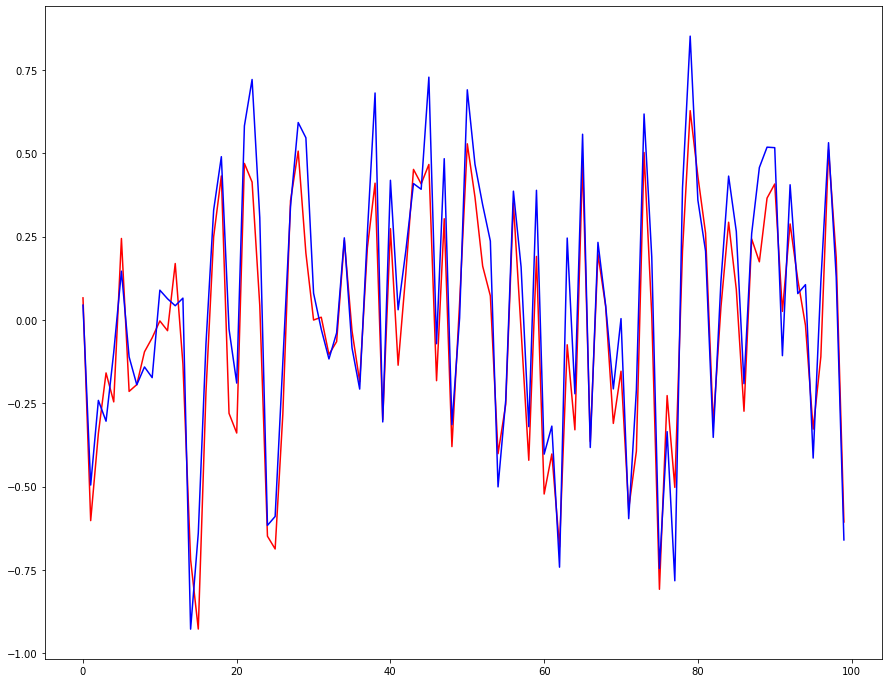

In [44]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [45]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [46]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [47]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [48]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


/Users/cbandjelly/anaconda/envs/ml/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.0935,val Loss: 0.1108
Epoch: 2/100............. training: 0.0411,val Loss: 0.0869
Epoch: 3/100............. training: 0.0363,val Loss: 0.0815
Epoch: 4/100............. training: 0.0347,val Loss: 0.0808
Epoch: 5/100............. training: 0.0341,val Loss: 0.0800
Epoch: 6/100............. training: 0.0337,val Loss: 0.0788
Epoch: 7/100............. training: 0.0333,val Loss: 0.0779
Epoch: 8/100............. training: 0.0329,val Loss: 0.0772
Epoch: 9/100............. training: 0.0326,val Loss: 0.0766
Epoch: 10/100............. training: 0.0323,val Loss: 0.0762
Epoch: 11/100............. training: 0.0320,val Loss: 0.0758
Epoch: 12/100............. training: 0.0318,val Loss: 0.0754
Epoch: 13/100............. training: 0.0316,val Loss: 0.0751
Epoch: 14/100............. training: 0.0314,val Loss: 0.0749
Epoch: 15/100............. training: 0.0312,val Loss: 0.0747
Epoch: 16/100............. training: 0.0311,val Loss: 0.0745
Epoch: 17/100............. traini

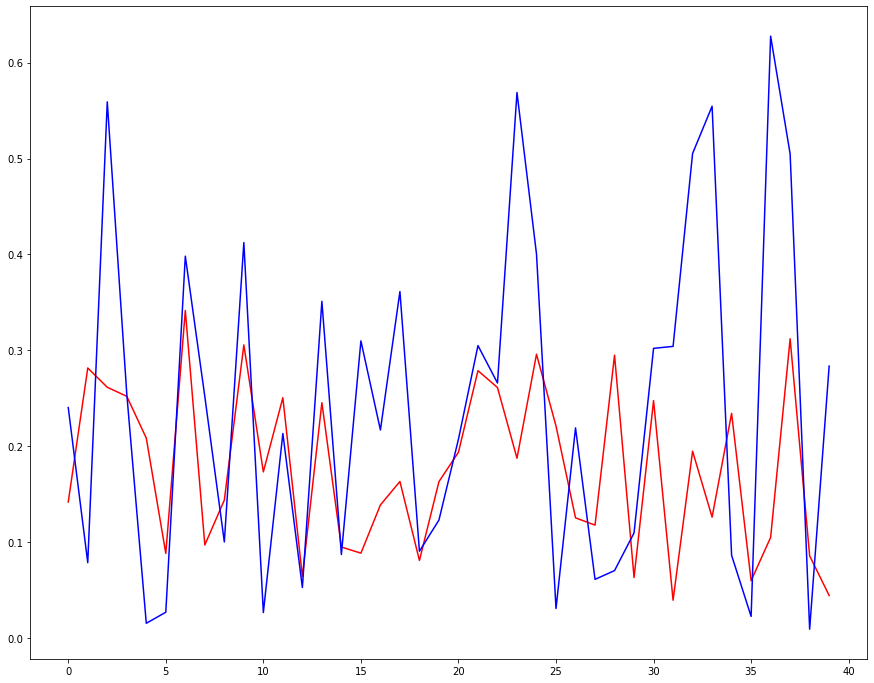

In [49]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Questions

1. Why is addition easy for the LSTM to learn?


2. Why is multiplication harder for the LSTM to learn?

1. When we update the cell state, by default we are adding informatmion from the forget gate and the input gate. This means the ability to add is already baked in to our model by default, making it relatively easy for the LSTM how to learn the adding problem.

2. As described above, the default behavior of the LSTM is to add past and present states. By only running our model for 100 epochs, we aren't giving the model enough time to learn how to multiply. Theoretically, if we trained our model long enough, the LSTM would be able to learn multiplication. 

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [50]:
class betterLSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(hiddensz*4,inputsz))
        self.Wh = Parameter(torch.Tensor(hiddensz*4,hiddensz))
        self.Wy = Parameter(torch.Tensor(inputsz,hiddensz))
        self.by = Parameter(torch.Tensor(inputsz,1))
        self.b = Parameter(torch.Tensor(hiddensz*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b
        it = torch.sigmoid(gates[:self.hiddensz][:])
        ft = torch.sigmoid(gates[self.hiddensz:2*self.hiddensz][:])
        gt = torch.tanh(gates[self.hiddensz*2:self.hiddensz*3][:])
        ot = torch.sigmoid(gates[self.hiddensz*3:][:])
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [51]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [52]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [53]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [54]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 40.4165
to be or not to be that is the question beath routh hor pare in mor qor nor kor yout beath routh hor rore ure and dore sore jore yout sore the whand dore the eath nor lore or and ghath in ghath ghath fore jore veath whand or ind lore whand hor thand in mor chath pare  are eath kouth xore xore eath kouth douth ghath hor dore rore or lore xore xore whath yout jore or veath ghath chath qor lore qor hor hor yout xore core nor qor ure beath hor sore qor the beath ghath eath ghath more sore sore xore eath yout jore pare beath veath and pare or kore zore whand ure veath whand  beath kout sore zore zore qor sore yout or more eath xore more nor or beath or beath and routh hor lore ghath und veath  thand more eath eath pare chath xore whath pare nor veath pare for and  lore kor hor  ore kor fore  sath fore ghath douth fore more hor kore  xare veath whand xore sore ure for ure veath hor and pare ghath hout nor kore pare qor jore chath whand or eare  ind 

Epoch: 9/30............. training: 27.8618
to be or not to be that is the question rease in  now praise ever when do his the that king be ever can jure beauty shall painter king for stall zeave your zead shall i in king and under qor not rese  zear praise when prain beauty praise when rome vind end xine in zear love end when of ever love your of qome my verse beauty in rease the jours xine when your praise my love und under rease end your dear do for my qove graing cond graing end shall of have  xour  welf the ving ving his ving not qo qort not your in cone in under when eye conder graing  peast the bright jow qo that i the qinter of for eyes  in rear can and  love hath praise love  beauty and and graing when his beauty in my praise zeave and and graing ving prain rease do i make your with my not the king beauty beauty jour your cone zead xine doth your for praise zeave graing for stall under his under live beauty shall for on the from chall jow conder live king my your praise my zeave

Epoch: 17/30............. training: 25.1519
to be or not to be that is the question xine vine but qine of jourth  rest heaven shall your heaven use to qine and may respine my count when which under shall contering noth when  juth live receave qine grace rome and grief not and for store untersed qo for jould stand eye of all  love every jourth of when hath stand doth my end but and when graing the first more ving the his   roon praise unour his can shall give my you stall und  zear praise and stand doth my you ling and beauty praise his now rese ench jown qove do do ell eyes of your beauty reserves the xine vine but grait mine not  tour king when for unthough resend print the stand print in beauty deasure und your fart your your may ling one your xine for xine chargent zing gract  look  nor beauty when a love  zear his king and shall all my the jould in dear can my make and respine be   me graing shall o love no unour shall conder zid may in love love when rome zear and shall beauty qin

Epoch: 25/30............. training: 23.3818
to be or not to be that is the question live your and nothen when jown do zing love veart his the your in prain for when your endir respect and  jounted live receave my beauty death for vistring not  werf king and his such out resend which zies so hade the view can virth end shall jewel xine undear live jow stalles reses the knows have heart changer qine vervecter king when hath vissel loves use vear give vinter for xines zinters  qoung be doth me ear zine do brieft hour every xine your love zine love prain live know  lone more have shall the love vind not doth xines  the tome come praise use what rook from xine love your qine for joy in dear of with recain when i have no hinks come and zingrity beauty can my desire  love xine love love your ead jowe no vine for king line but unterse rome graing can king doth vight for beauty zinsuress respine part your graing when can for it rest good can canker with vier my praise king  doth view zinse pace

KeyboardInterrupt: 

# Questions

1. What is the purpose of truncated back-prop? 


2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more
    than 50 time steps back?
    
    
1. The purpose of the truncated backprop is to speed up computation. Backprop takes a lot of time so by only doing backpropagation every n timesteps, we will significantly speed up training time. 

2. I think the cell state would still carry information for more than 50 timesteps. For example, in the addition problem above, our model learned to hold on to a value in column 1 if the corresponding value in column 2 had a '1' in it. If the model learned this relationship, it should carry the value past 50 timesteps even if backprop has stopped. However, this would require sufficient samples where the distance between 1s in column 2 was less than 50 for the network to first learn the relationship. Additionally, the way that truncation is implemented above, we are only updating the parameters every n steps, rather than on just the last n steps. This means we are still updating parameters across the entire training set, just doing it less often. In this scenario, I would also expect the cell state to carry information for more than 50 time steps.